### import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
import lightgbm as lgb
from bayes_opt import BayesianOptimization

In [2]:
%matplotlib inline

### Placing modules on path and importing

In [2]:
curr_dir = os.getcwd()
parent_dir = os.path.split(curr_dir)[0]
sys.path.append(parent_dir)

In [3]:
from EDA import ExploratoryDataAnalysis
from metrics import get_metrics
from metrics import show_residual, show_actual_vs_prediction_plot

### Read data

In [4]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv("test.csv")

### Exploratory Data Analysis

##### selected columns for ML model

In [5]:
sel_cols = ['CNC', 'HRD', 'HRM', 'GR', 'ZDEN']

##### function for EDA on training dataset

In [6]:
def eda_processing(df, output1, output2, sel_cols):
    cols = sel_cols + ['DTC', 'DTS']
    
    eda = ExploratoryDataAnalysis()    
    df = eda.convert_missing_to_null(df, missing_value=-999)
    
    """ basic EDA """
    eda.describe_data(df)
    """ EDA plots """
    eda.exploratory_plots(df)
    
    df = df[cols]    
    
    df.dropna(inplace=True)    
    
    y2 = df[output2]
    df = df.drop([output2], axis=1)    
    X = df.drop([output1], axis=1)
    y1 = df[output1]
    Xy1 = pd.concat([X, y1], axis=1)
    
    return X, y1, Xy1, y2

##### function for splitting train.csv data into train and dev sets

In [7]:
def preprocessing(X, y1, y2):
    
    X_train, X_dev, y1_train, y1_dev = train_test_split(X, y1, test_size = 0.2, random_state = 0)
    X_train, X_dev, y2_train, y2_dev = train_test_split(X, y2, test_size = 0.2, random_state = 0)
    Xy1_train = pd.concat([X_train, y1_train], axis=1)
    Xy1_dev = pd.concat([X_dev, y1_dev], axis=1)
    Xy1_train_dev = pd.concat([Xy1_train, Xy1_dev], axis=0)

    return X_train, y1_train, X_dev, y1_dev, Xy1_train, Xy1_dev, Xy1_train_dev, y2_train, y2_dev

##### function for EDA on test.csv

In [8]:
def eda_processing_test(df_test, sel_cols):
    
    eda = ExploratoryDataAnalysis()    
    df_test = eda.convert_missing_to_null(df_test, missing_value=-999)
    
    """ basic EDA """
    eda.describe_data(df)
    """ EDA plots """
    eda.exploratory_plots(df)
    
    df_test = df_test[sel_cols]    
    X_test = df_test.dropna()
    
    return X_test

In [9]:
outputs = ["DTC", "DTS"]
output1 = "DTS" # The output column we want to keep in the df
output2 = list(set(outputs).difference(set([output1])))[0] # the second output column

#### EDA on train.csv

********** shape of dataframe is **************:
 (30143, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     29633 non-null  float64
 1   CNC     29408 non-null  float64
 2   GR      29889 non-null  float64
 3   HRD     29758 non-null  float64
 4   HRM     29758 non-null  float64
 5   PE      29464 non-null  float64
 6   ZDEN    29462 non-null  float64
 7   DTC     26089 non-null  float64
 8   DTS     25278 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB
********** dataframe info is **********:
 None
************** dataframe column stats are **************:
                 CAL           CNC            GR           HRD           HRM  \
count  29633.000000  29408.000000  29889.000000  29758.000000  29758.000000   
mean       8.654281      0.683437     47.780541     16.953912     14.492077   
std        1.749145     30.689679     51

C:\Users\YAORUGAN\AppData\Local\Continuum\anaconda3\envs\spwla_env\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


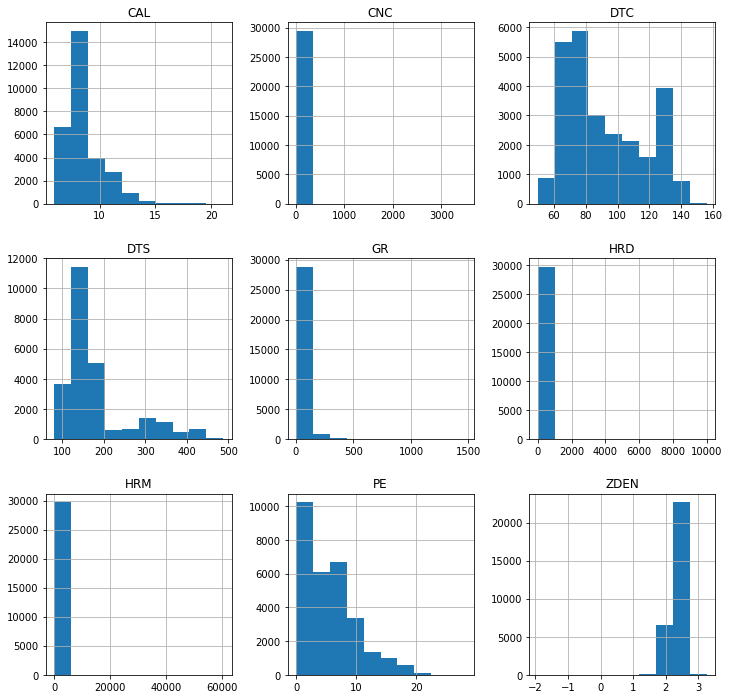

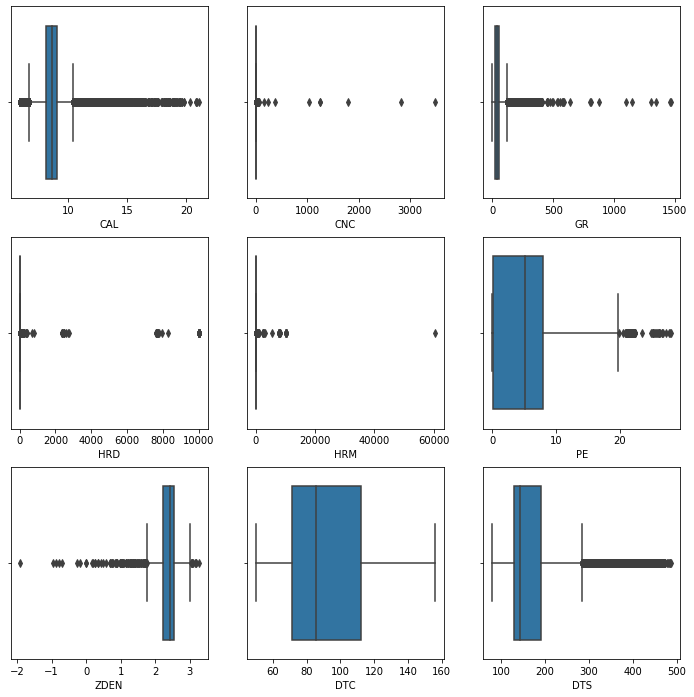

In [10]:
X, y1, Xy1, y2 = eda_processing(df, output1, output2, sel_cols)
X_train, y1_train, X_dev, y1_dev, Xy1_train, Xy1_dev, Xy1_train_dev, y2_train, y2_dev = preprocessing(X, y1, y2)

#### EDA on test.csv

********** shape of dataframe is **************:
 (30143, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     29633 non-null  float64
 1   CNC     29408 non-null  float64
 2   GR      29889 non-null  float64
 3   HRD     29758 non-null  float64
 4   HRM     29758 non-null  float64
 5   PE      29464 non-null  float64
 6   ZDEN    29462 non-null  float64
 7   DTC     26089 non-null  float64
 8   DTS     25278 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB
********** dataframe info is **********:
 None
************** dataframe column stats are **************:
                 CAL           CNC            GR           HRD           HRM  \
count  29633.000000  29408.000000  29889.000000  29758.000000  29758.000000   
mean       8.654281      0.683437     47.780541     16.953912     14.492077   
std        1.749145     30.689679     51

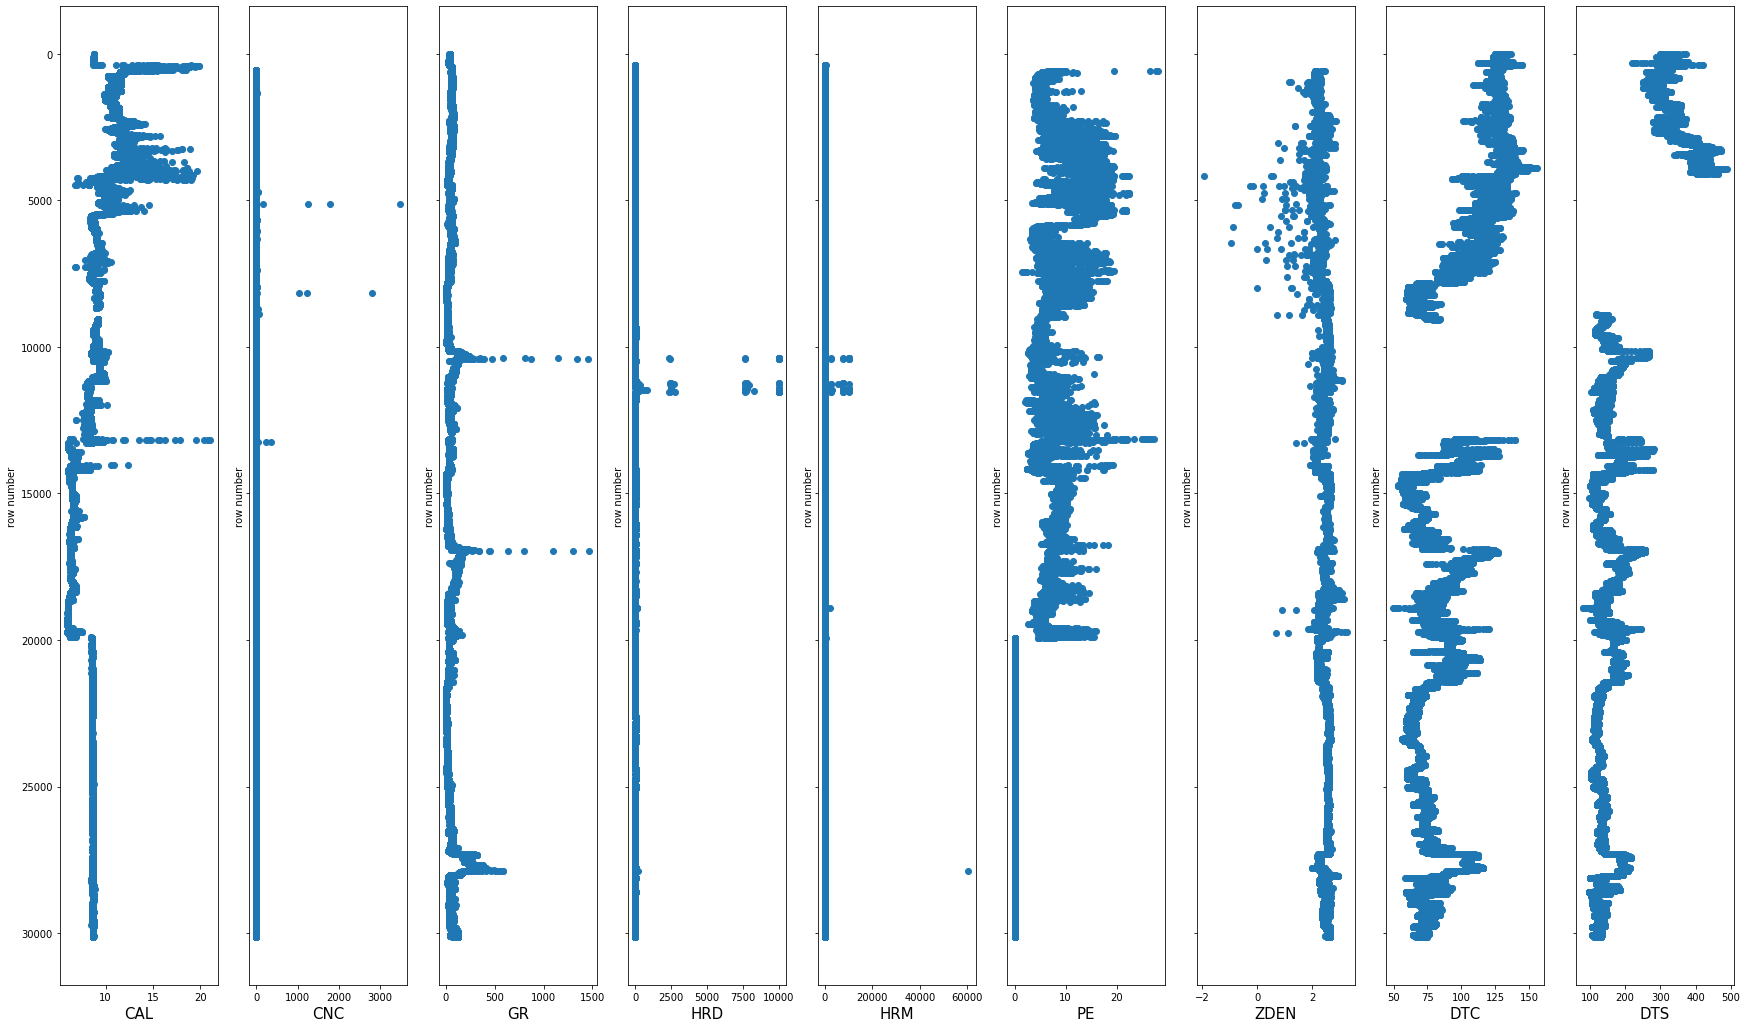

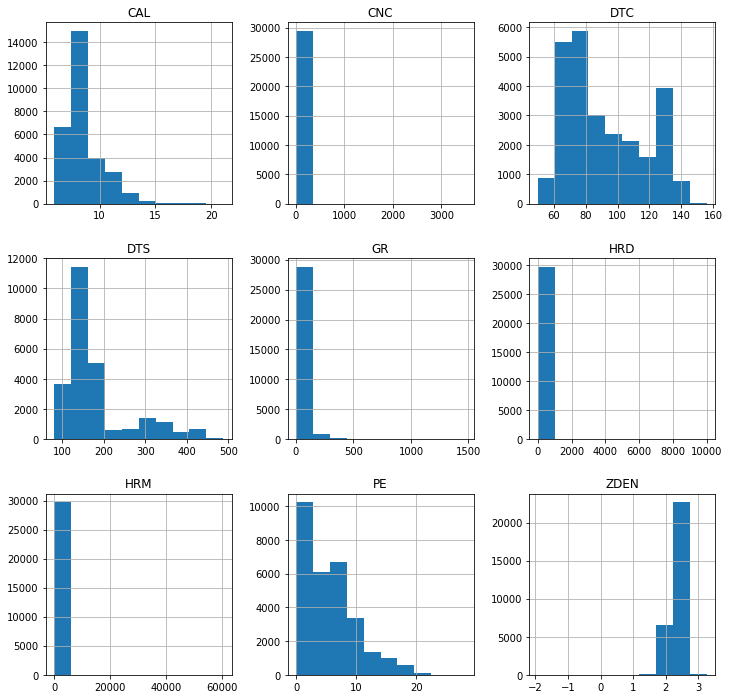

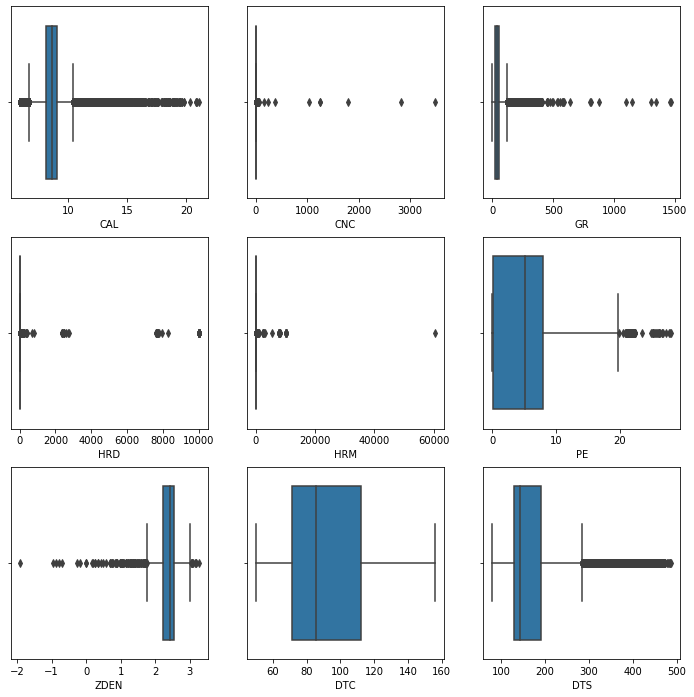

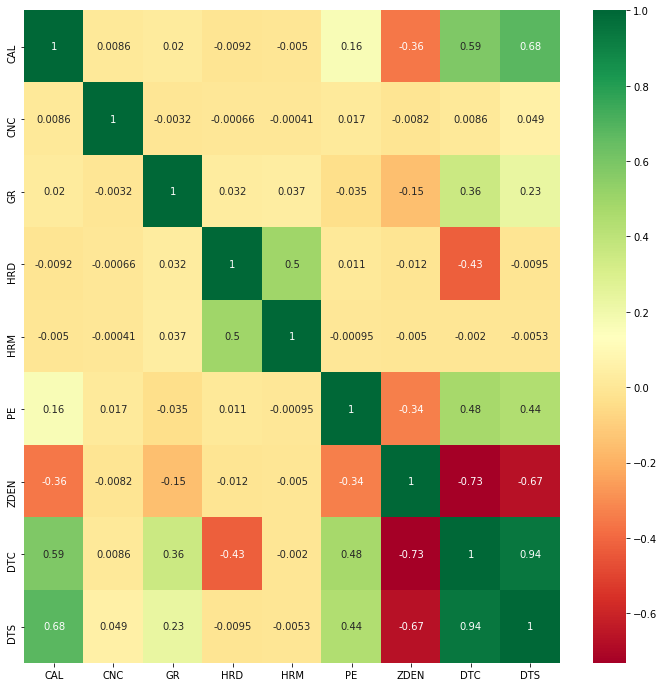

In [11]:
X_test = eda_processing_test(df_test, sel_cols)

### Bayesian Optimization for LightGBM model

In [13]:
# name of pickle file to write TPOT model to
fname = 'lgbm_base_featsel_DTS.pickle'
# directory to write pickle file to
lgbm_pickle_dir = "LGBM_pickle_models"

##### Parameters of the LightGBM model

In [14]:
params = {
            'boosting_type': 'dart',
            'objective': 'regression',
            'metric': {'l1', 'rmse'},
            'early_stopping_round': 50,
            'verbose': 0    
        }

##### function for Bayesian Optimization for determining optimal hyperparameters of LightGBM model

In [15]:
def bayesion_opt_lgbm(X, y, params, init_iter=3, n_iters=15, random_state=11, seed = 101):
    dtrain = lgb.Dataset(data=X, label=y)
    
    """ Objective Function for optimization """
    def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, \
                 min_child_weight, min_data_in_leaf, learning_rate, num_iterations):
        
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = feature_fraction #max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = bagging_fraction #max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['learning_rate'] = learning_rate
        params['num_iterations'] = int(round(num_iterations))
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,categorical_feature=[], stratified=False,
                          verbose_eval =None, metrics=['rmse']) #feval=lgb_r2_score)
       
        return -np.min(cv_results['rmse-mean'])
    
    """ Domain space: Range of hyperparameters """
    pds = {'num_leaves': (20, 80),
          'feature_fraction': (0.1, 0.9),
          'bagging_fraction': (0.8, 1),
          'max_depth': (5, 13),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (30, 50),
          'min_data_in_leaf': (15, 200),
          'learning_rate': (0.05, 0.15),
          'num_iterations': (100, 7000),      
          }

    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
    optimizer.maximize(init_points=init_iter, n_iter=n_iters)
    
    return optimizer.max['params'], optimizer

##### training the model

In [ ]:
opt_params, optimizer = bayesion_opt_lgbm(X_train, y1_train, params, init_iter=5, n_iters=10, random_state=77, seed = 101)
print(f"optimal hyperparameters are: {opt_params}")

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | min_sp... | num_it... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


C:\Users\YAORUGAN\AppData\Local\Continuum\anaconda3\envs\spwla_env\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\YAORUGAN\AppData\Local\Continuum\anaconda3\envs\spwla_env\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\YAORUGAN\AppData\Local\Continuum\anaconda3\envs\spwla_env\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\YAORUGAN\AppData\Local\Continuum\anaconda3\envs\spwla_env\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode


##### Retrieving best LightGBM model

In [19]:
def optimal_lgbm(params, opt_params, X_train, y_train):
    opt_params["num_leaves"] = int(round(opt_params["num_leaves"]))
    opt_params['max_depth'] = int(round(opt_params['max_depth']))
    opt_params['min_data_in_leaf'] = int(round(opt_params['min_data_in_leaf']))
    opt_params['num_iterations'] = int(round(opt_params['num_iterations']))

    params.update(opt_params)

    lgb_train = lgb.Dataset(X_train, y_train)

    lightgbm = lgb.train(params, lgb_train)
    return lightgbm

In [20]:
best_model = optimal_lgbm(params, opt_params, X_train, y1_train)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


##### Writing best model to pickle file

In [21]:
if not os.path.exists(lgbm_pickle_dir):
    os.mkdir(lgbm_pickle_dir)
fpath = os.path.join(lgbm_pickle_dir, fname)
pickle.dump(best_model, open(fpath, "wb"))

##### loading model from pickle file (use this if you have a pickle model)

In [22]:
fpath = os.path.join(lgbm_pickle_dir, fname)
best_model = pickle.load(open(fpath, "rb"))

##### feature importances

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(best_model, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance")

Text(0.5, 1.0, 'LightGBM - Feature Importance')

### Best model predictions and metrics

In [24]:
def predictions_metrics(best_model, X_train, y1_train, X_dev, y1_dev, X_test, output):
    y1_train_pred = best_model.predict(X_train)
    y1_train_pred = pd.Series(y1_train_pred, name=str(output + "_y_pred"), index=X_train.index)
    
    y1_dev_pred = best_model.predict(X_dev)    
    y1_dev_pred = pd.Series(y1_dev_pred, name=str(output + "_y_pred"), index=X_dev.index)
    
    train_flag = pd.Series(["train"]*X_train.shape[0], name="train_dev_flag", index=X_train.index)
    dev_flag = pd.Series(["dev"]*X_dev.shape[0], name="train_dev_flag", index=X_dev.index)

    y1_test_pred = best_model.predict(X_test)    
    y1_test_pred = pd.Series(y1_test_pred, name=str(output + "_y_pred"), index=X_test.index)
    
    Xy1_train_pred = pd.concat([X_train, y1_train, y1_train_pred, train_flag], axis=1)
    Xy1_dev_pred = pd.concat([X_dev, y1_dev, y1_dev_pred, dev_flag], axis=1) # this is the independent dev set from splitting train.csv
    Xy1_train_dev_pred = pd.concat([Xy1_train_pred, Xy1_dev_pred], axis=0)
    Xy1_test_pred = pd.concat([X_test, y1_test_pred], axis=1) # This is the independent test set from test.csv
    
    print(get_metrics(y1_train, y1_train_pred))
    print(get_metrics(y1_dev, y1_dev_pred))
    
    return Xy1_train_pred, y1_train_pred, Xy1_dev_pred, y1_dev_pred, Xy1_train_dev_pred, Xy1_test_pred, y1_test_pred

In [25]:
Xy1_train_pred, y1_train_pred, Xy1_dev_pred, y1_dev_pred, Xy1_train_dev_pred, \
Xy1_test_pred, y1_test_pred = predictions_metrics(best_model, X_train, y1_train, X_dev, y1_dev, X_test, output1)

root_mean_squared_error                5.21
normalized_root_mean_squared_error     0.03
neg_mean_squared_error               -27.16
root mean squared log error            0.03
mean absolute percentage error         1.98
r2_score                               1.00
mean_absolute_error                    3.44
explained_variance                     1.00
dtype: float64
root_mean_squared_error                12.55
normalized_root_mean_squared_error      0.07
neg_mean_squared_error               -157.59
root mean squared log error             0.06
mean absolute percentage error          3.70
r2_score                                0.98
mean_absolute_error                     6.72
explained_variance                      0.98
dtype: float64


### Saving the predictions

In [26]:
fname_prefix = "lgbm_base_featsel"
output_fname1 = fname_prefix + "__DTC_train_dev.csv"
output_fname2 = fname_prefix + "_DTC_test.csv"
output_fname3 = fname_prefix + "_DTS_train_dev.csv"
output_fname4 = fname_prefix + "_DTS_test.csv"

In [27]:
if output1 == "DTC":    
    output_fname_train_dev = output_fname1
    output_fname_test = output_fname2
elif output1 == "DTS":
    output_fname_train_dev = output_fname3
    output_fname_test = output_fname4
Xy1_train_dev_pred.to_csv(output_fname_train_dev)
Xy1_test_pred.to_csv(output_fname_test)

### Plots

In [ ]:
show_residual(y1_dev_pred.values-y1_dev.values, 'Dev Data', 'orange')

In [ ]:
show_residual(y1_train_pred.values-y1_train.values, 'Training Data', 'steelblue')

In [ ]:
show_actual_vs_prediction_plot(y1_dev_pred, y1_dev, 'DTS', 'Dev Data')

In [ ]:
show_actual_vs_prediction_plot(y1_train_pred, y1_train, 'DTS', 'Training Data')

### Calculating combined RMSE of DTC and DTS predictions 

In [28]:
def combined_rmse(yc_dev, yc_dev_pred, ys_dev, ys_dev_pred):
    m = yc_dev.shape[0]
    _combined_rmse = (0.5 * (1/m) * (np.sum((yc_dev-yc_dev_pred)**2) + np.sum((ys_dev-ys_dev_pred)**2)))**0.5
    return _combined_rmse

##### filenames of files with DTC and DTS prediction results

In [30]:
fname_prefix_DTC_model = "tpot_base_featsel_outrem"
fname_prefix_DTS_model = "lgbm_base_featsel_outrem"
output_fname1 = fname_prefix_DTC_model + "_DTC_train_dev.csv"
output_fname2 = fname_prefix_DTC_model + "_DTC_test.csv"
output_fname3 = fname_prefix_DTS_model + "_DTS_train_dev.csv"
output_fname4 = fname_prefix_DTS_model + "_DTS_test.csv"

##### read results from csv for DTC and DTS and return combined RMSE of dev set

In [31]:
try:
    """ read results from csv for DTC and DTS """
    X_DTC_train_dev = pd.read_csv(output_fname1, index_col=0)
    X_DTC_test_dev = pd.read_csv(output_fname2, index_col=0)
    X_DTS_train_dev = pd.read_csv(output_fname3, index_col=0)
    X_DTS_test_dev = pd.read_csv(output_fname4, index_col=0)
    
    yc_dev = X_DTC_train_dev.loc[X_DTC_train_dev["train_dev_flag"]=="dev", "DTC"]
    yc_dev_pred = X_DTC_train_dev.loc[X_DTC_train_dev["train_dev_flag"]=="dev", "DTC_y_pred"]
    ys_dev = X_DTS_train_dev.loc[X_DTS_train_dev["train_dev_flag"]=="dev", "DTS"]
    ys_dev_pred = X_DTS_train_dev.loc[X_DTS_train_dev["train_dev_flag"]=="dev", "DTS_y_pred"]

    _combined_rmse = combined_rmse(yc_dev, yc_dev_pred, ys_dev, ys_dev_pred)
    y_real = pd.concat([yc_dev, ys_dev], axis=1)
    y_pred = pd.concat([yc_dev_pred, ys_dev_pred], axis=1)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    print(f"combined rmse is: {_combined_rmse}")
    print(rmse)
except Exception as e:
    print("both yc_test_pred and ys_test_pred need to be present")
    print(e)

both yc_test_pred and ys_test_pred need to be present
File b'sog_tpot_base_featsel_outrem_DTC_train_dev.csv' does not exist
